**Problem:**    almost impossible to use thin section description for rock typing. Lots of plain text of every sample needed to be read.

**Solution:**   convert the text using pattern recognition, plain text => squared logs

**Tools:**      large language model (LLM) -- Open AI API (model = 'gpt-3.5-turbo')

**How:**        parameter = noun, value of the parameter = adjective describing the noun

In [6]:
import pandas as pd

import openai
import lasio

from apikey import APIKEY
openai.api_key = APIKEY

In [7]:
def outputGPTurbo(myMessage, max_tokens):
    output = openai.ChatCompletion.create(
        model = 'gpt-3.5-turbo', 
        messages = [{
        'role':'user',
        'content':myMessage 
        }],
        temperature = 0,
        max_tokens = max_tokens
    )

    return output["choices"][0]["message"]["content"].strip()

**Parameters that important here, of openai.ChatCompletion.create():**
- temperature   ~ creativity (should be low for the task)
- max_tokens    ~ words processing, 1 token is about 1.4 words

<br>
<br>
<br>

**Let's open xls with this section description:**



In [8]:
dfThinSectDescr = pd.read_excel('ThinSectDescrExampl.xls')
dfThinSectDescr.head()

,Measured depth,ID,"Phi, v/v","GD, g/cc","K, mD",Lithofacies,Allochems Non-Skeletal Grains,Allochems Skeletal Grains,Energy,Reservoir Properties,Rock Fabric,Textural
0,1,1,0.123,2.70,0.95,RPF,Common indistinct and distinct peloids are pre...,"Common benthic foraminifera (inc. miliolids, r...",Based on the sedimentary features and grain as...,"Visible porosity appearsmoderate, characterize...","This is a poorly sorted, indistinctly bioturba...","Rudist, peloidal Floatstone"
1,2,2,0.194,2.70,5.60,SPP,Common indistinct and distinct peloids are pre...,"Common benthic foraminifera (inc. miliolids, r...","moderate-energy, shoal-flanking depositional e...",Visible porosity is moderateto good and includ...,"A poorly sorted, indistinctly bioturbated, ske...","Skeletal, peloidal Packstone"
2,3,3,0.197,2.70,44.00,RPF,Common indistinct and distinct peloids are pre...,"Common benthic foraminifera (inc. miliolids, r...",The allochem assemblage and sedimentary charac...,Visible porosity is moderate togood and includ...,"This is a poorly sorted, indistinctly bioturba...","Rudist, peloidal Floatstone"
3,4,4,0.212,2.70,2.80,SPP,Common indistinct and distinct peloids are pre...,"Common poorly preserved, micritized benthic fo...","Deposition in a moderate-energy backshoal, or ...","Visible porosity is moderateto good, character...","A poorly sorted, indistinctly bioturbated skel...","Peloidal, skeletal Packstone"
4,5,5,0.205,2.69,2.10,SPP,Common indistinct and distinct peloids are pre...,"Common echinoderm debris, minor Lithocodium/Ba...",The allochem assemblage and the sedimentary ch...,"Visible porosity is moderateto good, character...","This is a poorly sorted, indistinctly bioturba...","Skeletal, peloidal Packstone"


In [9]:
print(dfThinSectDescr['Reservoir Properties'][0])

Visible porosity appearsmoderate, characterized by minor to common mouldic, intraparticle and vuggy macropores, along withrare to minor grain and matrix-hosted microporosity. The measured value is agreeable with the observedvolume. However, common cementation has degraded connectivity and common cracks and fracturesmay have affected the measured permeability value. Therefore, a poor to possibly moderate reservoirquality is inferred.Open cracks and fractures are interpreted to be artefacts from sample preparation.


<br>
<br>

**Let's use 'Reservoir Properties' column to convert it to squared logs. Taking in 1 string columns 'Measured depth' and 'Reservoir Properties':**

In [10]:
resProp = ''

for ind in dfThinSectDescr.index:
    resProp += str(dfThinSectDescr['Measured depth'][ind]) + '\n' + dfThinSectDescr['Reservoir Properties'][ind] + '\n'

In [11]:
print(resProp)

1
Visible porosity appearsmoderate, characterized by minor to common mouldic, intraparticle and vuggy macropores, along withrare to minor grain and matrix-hosted microporosity. The measured value is agreeable with the observedvolume. However, common cementation has degraded connectivity and common cracks and fracturesmay have affected the measured permeability value. Therefore, a poor to possibly moderate reservoirquality is inferred.Open cracks and fractures are interpreted to be artefacts from sample preparation.
2
Visible porosity is moderateto good and includes minor to common secondary mouldic, intraparticle and vuggy macropores, alongwith minor grain and matrix-hosted micropores. The measured value is agreeable with the observedvolume. However, common cementation has degraded connectivity and macropores are commonlyisolated. Hence, a moderate reservoir quality is inferred.
3
Visible porosity is moderate togood and includes minor to common secondary mouldic, intraparticle and larg

<br>
<br>

**Prompt for the LLM.**

**It's a draft example prompt, and the model can be fine-tuned if needed.**

In [12]:
prompt = 'return a table: rows as reference indexes (number before every article) and columns as parameters. General rules: noun or phrase that appears or not in articles is a parameter. The text or adjectives describing every noun/phrase is a value of this parameter. \n\n'

In [13]:
tableResProp = outputGPTurbo(prompt + resProp, max_tokens=1000)
print(tableResProp)

| Reference Index | Visible Porosity | Macropores | Microporosity | Cementation | Fractures |
| --- | --- | --- | --- | --- | --- |
| 1 | Moderate | Rare to minor mouldic, intraparticle and vuggy | Rare to minor grain and matrix-hosted | Common | Common cracks and fractures |
| 2 | Moderate to good | Minor to common secondary mouldic, intraparticle and vuggy | Minor grain and matrix-hosted | Common | Macropores commonly isolated |
| 3 | Moderate to good | Minor to common secondary mouldic, intraparticle and large vuggy | Minor to common grain and matrix-hosted | Common, unevenly distributed | Large, possible artefact vugs |
| 4 | Moderate to good | Minor secondary mouldic, intraparticle and large vuggy | Minor to common grain and matrix-hosted | Isolated macropores, cementation and clay/organic matter content | N/A |
| 5 | Moderate to good | Rare mouldic macropores, minor secondary intraparticle | Common grain and matrix-hosted | Neomorphism of the micrite matrix, compaction and cement

<br>
<br>

**Let's return it as a pd-dataframe:**

In [15]:
promptDF = 'return a pandas data frame from this: '
dfResProp = outputGPTurbo(promptDF + tableResProp, max_tokens=1000)

In [16]:
print(dfResProp)

import pandas as pd

data = {'Reference Index': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17],
        'Visible Porosity': ['Moderate', 'Moderate to good', 'Moderate to good', 'Moderate to good', 'Moderate to good', 'Moderate to good', 'Moderate to good', 'Moderate to good', 'Moderate', 'Moderate to good', 'Moderate to good', 'Moderate to good', 'Moderate', 'Moderate to good', 'Moderate to good', 'Moderate to good', 'Moderate'],
        'Macropores': ['Rare to minor mouldic, intraparticle and vuggy', 'Minor to common secondary mouldic, intraparticle and vuggy', 'Minor to common secondary mouldic, intraparticle and large vuggy', 'Minor secondary mouldic, intraparticle and large vuggy', 'Rare mouldic macropores, minor secondary intraparticle', 'Minor secondary intraparticle, mouldic and vuggy', 'Common interparticle, primary and secondary intraparticle, mouldic and vuggy', 'Common interparticle, primary and secondary intraparticle and mouldic', 'Minor mouldic and intraparti

In [17]:
exec(dfResProp[:-9])

In [18]:
df = df.add_prefix('ResProp_')

In [19]:
df.head()

,ResProp_Reference Index,ResProp_Visible Porosity,ResProp_Macropores,ResProp_Microporosity,ResProp_Cementation,ResProp_Fractures
0,1,Moderate,"Rare to minor mouldic, intraparticle and vuggy",Rare to minor grain and matrix-hosted,Common,Common cracks and fractures
1,2,Moderate to good,"Minor to common secondary mouldic, intrapartic...",Minor grain and matrix-hosted,Common,Macropores commonly isolated
2,3,Moderate to good,"Minor to common secondary mouldic, intrapartic...",Minor to common grain and matrix-hosted,"Common, unevenly distributed","Large, possible artefact vugs"
3,4,Moderate to good,"Minor secondary mouldic, intraparticle and lar...",Minor to common grain and matrix-hosted,"Isolated macropores, cementation and clay/orga...",N/A
4,5,Moderate to good,"Rare mouldic macropores, minor secondary intra...",Common grain and matrix-hosted,"Neomorphism of the micrite matrix, compaction ...",N/A


<br>
<br>

**Evrth is kinda ready, converting the results to las or csv:**

In [20]:
las = lasio.LASFile()
from datetime import datetime
las.well.DATE = datetime.today().strftime('%Y-%m-%d %H:%M:%S')
las.header

{'Version': [HeaderItem(mnemonic="VERS", unit="", value="2.0", descr="CWLS log ASCII Standa"),
  HeaderItem(mnemonic="WRAP", unit="", value="NO", descr="One line per depth ste"),
  HeaderItem(mnemonic="DLM", unit="", value="SPACE", descr="Column Data Section ")],
 'Well': [HeaderItem(mnemonic="STRT", unit="m", value="nan", descr="START DEPTH"),
  HeaderItem(mnemonic="STOP", unit="m", value="nan", descr="STOP DEPTH"),
  HeaderItem(mnemonic="STEP", unit="m", value="nan", descr="STEP"),
  HeaderItem(mnemonic="NULL", unit="", value="-9999.25", descr="NULL VALUE"),
  HeaderItem(mnemonic="COMP", unit="", value="", descr="COMPANY"),
  HeaderItem(mnemonic="WELL", unit="", value="", descr="WELL"),
  HeaderItem(mnemonic="FLD", unit="", value="", descr="FIELD"),
  HeaderItem(mnemonic="LOC", unit="", value="", descr="LOCATION"),
  HeaderItem(mnemonic="PROV", unit="", value="", descr="PROVINCE"),
  HeaderItem(mnemonic="CNTY", unit="", value="", descr="COUNTY"),
  HeaderItem(mnemonic="STAT", unit=""

In [21]:
df.rename(columns = {'ResProp_Reference Index':'Measured depth'}, inplace = True)

In [22]:
las.append_curve(df.columns[0], df['Measured depth'].to_numpy(), 'm', df.columns[0])

In [23]:
las.header

{'Version': [HeaderItem(mnemonic="VERS", unit="", value="2.0", descr="CWLS log ASCII Standa"),
  HeaderItem(mnemonic="WRAP", unit="", value="NO", descr="One line per depth ste"),
  HeaderItem(mnemonic="DLM", unit="", value="SPACE", descr="Column Data Section ")],
 'Well': [HeaderItem(mnemonic="STRT", unit="m", value="nan", descr="START DEPTH"),
  HeaderItem(mnemonic="STOP", unit="m", value="nan", descr="STOP DEPTH"),
  HeaderItem(mnemonic="STEP", unit="m", value="nan", descr="STEP"),
  HeaderItem(mnemonic="NULL", unit="", value="-9999.25", descr="NULL VALUE"),
  HeaderItem(mnemonic="COMP", unit="", value="", descr="COMPANY"),
  HeaderItem(mnemonic="WELL", unit="", value="", descr="WELL"),
  HeaderItem(mnemonic="FLD", unit="", value="", descr="FIELD"),
  HeaderItem(mnemonic="LOC", unit="", value="", descr="LOCATION"),
  HeaderItem(mnemonic="PROV", unit="", value="", descr="PROVINCE"),
  HeaderItem(mnemonic="CNTY", unit="", value="", descr="COUNTY"),
  HeaderItem(mnemonic="STAT", unit=""

In [24]:
for k in range(1, len(df.columns)):
    las.append_curve(df.columns[k], 
                     df[df.columns[k]].to_numpy(), 
                     'unitless', 
                     df.columns[k])

In [25]:
las.header

{'Version': [HeaderItem(mnemonic="VERS", unit="", value="2.0", descr="CWLS log ASCII Standa"),
  HeaderItem(mnemonic="WRAP", unit="", value="NO", descr="One line per depth ste"),
  HeaderItem(mnemonic="DLM", unit="", value="SPACE", descr="Column Data Section ")],
 'Well': [HeaderItem(mnemonic="STRT", unit="m", value="nan", descr="START DEPTH"),
  HeaderItem(mnemonic="STOP", unit="m", value="nan", descr="STOP DEPTH"),
  HeaderItem(mnemonic="STEP", unit="m", value="nan", descr="STEP"),
  HeaderItem(mnemonic="NULL", unit="", value="-9999.25", descr="NULL VALUE"),
  HeaderItem(mnemonic="COMP", unit="", value="", descr="COMPANY"),
  HeaderItem(mnemonic="WELL", unit="", value="", descr="WELL"),
  HeaderItem(mnemonic="FLD", unit="", value="", descr="FIELD"),
  HeaderItem(mnemonic="LOC", unit="", value="", descr="LOCATION"),
  HeaderItem(mnemonic="PROV", unit="", value="", descr="PROVINCE"),
  HeaderItem(mnemonic="CNTY", unit="", value="", descr="COUNTY"),
  HeaderItem(mnemonic="STAT", unit=""

In [26]:
las.write('scratch_v2.las', version=2)
las.to_csv('scratch_v2.csv')

<br>
<br>

**This is how the final csv-file can look like:**

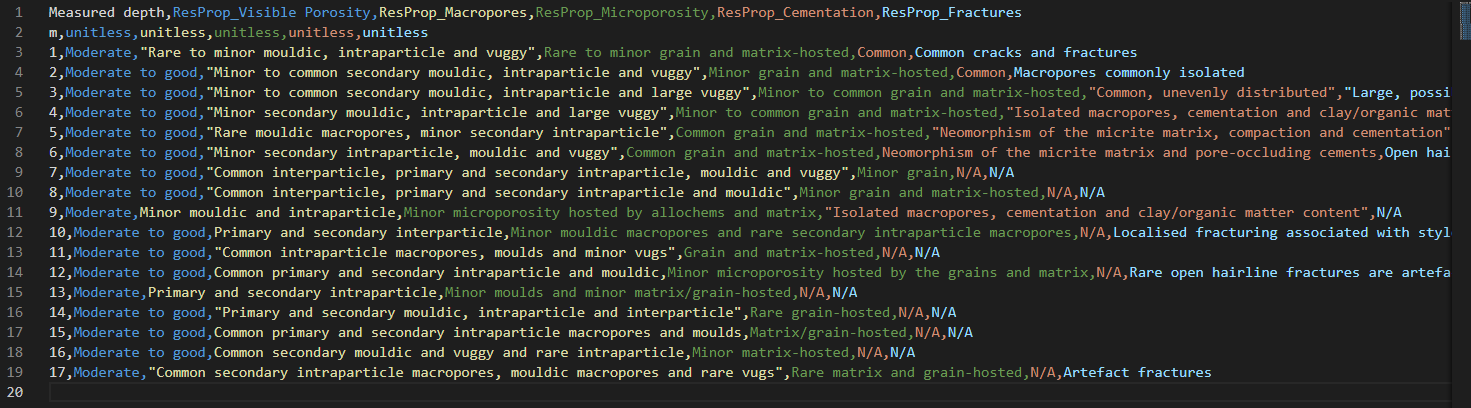